In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.linalg as la

In [3]:
import seaborn as sn
import matplotlib.font_manager as fm

In [4]:
font_path = "/Users/pedrobraga/Documents/Cambridge/wa_two/cmunci.ttf"
custom_font = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = custom_font.get_name()
sn.set(font=custom_font.get_name())

base = {
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.bottom": True,
    "xtick.top": True,
    "ytick.left": True,
    "ytick.right": True,
}

sn.set_theme(context='notebook', style=base, palette='rocket_r', color_codes=True, rc=None)

In [5]:
# --- global variables --- #

hbar = 0.658 # eV fs
m0 = 5.6856800 # fs{2] eV nm{-2} 
mu = 0.108 * m0 # eV

veps0 = 5.52638e-2 # c{2} eV{-1} nm{-1}
vepsS = 3.32 # dimless
vepsW = 6.10 # dimless

Lwell = 0.636 # nm
r0 = Lwell * vepsW/(2*vepsS) # nm

A = Lwell**2 # nm{2}


In [6]:
# --- simulation parameters --- #

k_max = .75
N = 500
dk = k_max/N

k_vals = np.linspace(dk, k_max, N)

th_max = 2*np.pi
Th = 250
dth = th_max/Th

cos_vals = np.cos(np.linspace(dth, th_max, Th))

In [7]:
def RytovaKeldysh(ki, kj): # Riemann sum over thetas

    if ki == kj:
        q = np.sqrt(ki**2 + kj**2 - 2*ki*kj*cos_vals[:-1]) # to deal with discontinuity ignore cos(theta) = 1
    else:
        q = np.sqrt(ki**2 + kj**2 - 2*ki*kj*cos_vals)

    Vl = 1/(q * (1 + r0*q))
    Constants = 1 /(2 * veps0 * vepsS * Lwell**2)

    V = np.sum(Vl) * Constants

    return dth * A * V / (4 * np.pi**2)

def Coulomb(): # Riemann sum of the kj components

    V = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
               
            V[i][j] = dk * k_vals[j] * RytovaKeldysh(k_vals[i], k_vals[j])

    return V

In [8]:
def WannierMatrix(): # construction of the Wannier matrix

    K = np.diag( hbar**2 * k_vals**2/(2 * mu) )

    H = K - Coulomb()

    np.savetxt("Hamiltonian.txt", H, fmt="%.10f")
    np.savetxt("Kinetic.txt", K, fmt="%.10f")
    np.savetxt("Coulomb.txt", Coulomb(), fmt="%.10f")

    return H

In [9]:
def EigenvectorsNorm(eigvec):

    Nv = np.zeros((N,N))

    # Similar to josh's
    for i in range(N):

        norm = 0
        for j in range(N):
            norm += 1/(2*np.pi)*k_vals[j]*dk*np.absolute(eigvec[j,i])**2 # calculate the integral on kj over |eigenfunction(ki,kj)|^2 considering the constants

        for j in range(N):
            Nv[j,i] = eigvec[j,i] / np.sqrt(norm) # divide each of the eigenfunctions by the required constant norm to get it over one'''

    np.savetxt('NVectors.txt', Nv, fmt="%.10f")

    return Nv

def Sorting(values, n): # making sure we are printing the eigenvectors for the lowest eigenvalues

    eigenvaluesDict = {value: index for index, value in enumerate(eigenvalues, start=0)}
    sortedEigenvalues = sorted(eigenvalues)

    output = np.zeros(n) # indexes of the correct eigenvectors

    for i in range(n):
        output[i] = eigenvaluesDict[sortedEigenvalues[i]]

    np.savetxt('SortedEigenvalues.txt', sortedEigenvalues, fmt="%.10f")

    return output

        

In [10]:
eigenvalues, eigenvectors = np.linalg.eig(WannierMatrix())
eigenvalues_SCP, eigenvectors_SCP = la.eig(WannierMatrix())
norm_eigenvectors = EigenvectorsNorm(eigenvectors_SCP)

In [11]:
indexes = Sorting(eigenvalues, 10)

s1 = int(indexes[0])
s2 = int(indexes[1])
s3 = int(indexes[2])
s4 = int(indexes[3])
s5 = int(indexes[4])

levels = [s1, s2, s3, s4, s5]
levels_10 = [s1, s2, s3, s4,s5,int(indexes[5]),int(indexes[6]),int(indexes[7]),int(indexes[8]),int(indexes[9])]
eig_levels = [(-1)* eigenvalues[s1],(-1)*  eigenvalues[s2],(-1)*  eigenvalues[s3],(-1)*  eigenvalues[s4],(-1)*  eigenvalues[s5]]

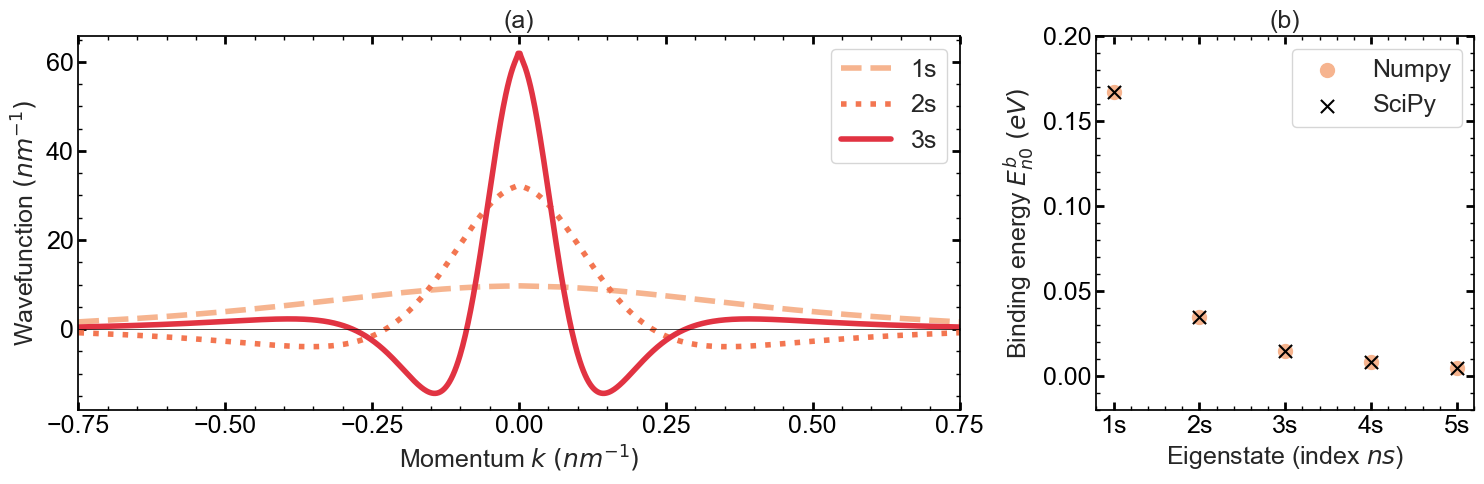

In [14]:
plot_x = np.concatenate((np.flip((-1) * k_vals), k_vals))

fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [14, 6]})

# --- numpy eigenvalues function --- #

axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, s1]), norm_eigenvectors[:, s1])), label=f'1s', linewidth=4, linestyle='--')
axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, s2]), norm_eigenvectors[:, s2])), label=f'2s', linewidth=4, linestyle=':')
axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, s3]), norm_eigenvectors[:, s3])), label=f'3s', linewidth=4)
#axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, s4]), norm_eigenvectors[:, s4])), label=f'4s', linewidth=3)
#axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, s5]), norm_eigenvectors[:, s5])), label=f'5s', linewidth=3)
axes[0].plot(plot_x, np.zeros(len(plot_x)), c='black', linewidth=0.5)
axes[0].set_xticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])

axes[0].set_xlabel('Momentum $k$ $(nm^{-1})$', fontsize=18)
axes[0].set_xlim(-.75, .75)
axes[0].set_ylabel('Wavefunction $(nm^{-1})$', fontsize=18)
axes[0].set_title('(a)', fontsize=18)
axes[0].legend(loc='upper right', fontsize=18)

axes[0].tick_params(axis="both", labelsize=18)
axes[0].tick_params(axis="both", which="major", direction="in", length=6, width=2)
axes[0].tick_params(axis="both", which="minor", direction="in", length=3, width=1.0)

axes[0].xaxis.set_major_locator(ticker.MultipleLocator(0.25))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(20))
axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(5))

axes[1].scatter(['1s', '2s' , '3s' , '4s', '5s'], eig_levels, s =100, label='Numpy')
axes[1].scatter(['1s', '2s' , '3s' , '4s', '5s'], eig_levels, s=90, label='SciPy', marker='x', color='black')
axes[1].set_ylim(-.02, .2)
axes[1].set_xlabel('Eigenstate (index $ns$)', fontsize=18)
axes[1].set_ylabel('Binding energy $E_{n0}^b$ $(eV)$', fontsize=18)
axes[1].set_title('(b)', fontsize=18)

axes[1].tick_params(axis="both", labelsize=18)
axes[1].tick_params(axis="both", which="major", direction="in", length=6, width=2)
axes[1].tick_params(axis="both", which="minor", direction="in", length=3, width=1.0)

axes[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axes[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(0.05))
axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

axes[1].legend(fontsize=18)

plt.tight_layout()
plt.savefig('eigen_results.pdf', dpi=800)

In [13]:
print(f"1s - 2s: {(eig_levels[0] - eig_levels[1])*1000}")
print(f"1s - 2s: {(eig_levels[1] - eig_levels[2])*1000}")
print(f"1s - 2s: {(eig_levels[2] - eig_levels[3])*1000}")
print(f"1s - 2s: {(eig_levels[3] - eig_levels[4])*1000}")

1s - 2s: 132.14646250441842
1s - 2s: 20.206159361364744
1s - 2s: 6.795719191095494
1s - 2s: 3.0821869652814216


In [14]:
def SavingValuesVectors():

    vectors = []

    for i in levels:
        vectors.append(norm_eigenvectors[:, i])

    #np.savetxt("EigenvaluesSlashed5.txt", eig_levels, fmt="%.10f")
    np.savetxt("EigenvectorsSlashed5.txt", vectors)

In [15]:
SavingValuesVectors()